<a href="https://colab.research.google.com/github/hargurjeet/NLP_Automatic_Ticket_Classification/blob/main/Automatic_Ticket_Classification_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import zipfile

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
!pip install gitpython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00


In [3]:
from git import Repo

# URL of the GitHub repository to clone
repo_url = 'https://github.com/hargurjeet/NLP_Automatic_Ticket_Classification.git'

# Directory where the repository will be cloned
clone_directory = '/content/git_repo'

# Clone the repository
Repo.clone_from(repo_url, clone_directory)

<git.repo.base.Repo '/content/git_repo/.git'>

In [4]:
import zipfile

def unzip_file(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Example usage
zip_path = '/content/git_repo/complaints-2021-05-14_08_16.zip'
extract_path = '/content/'
unzip_file(zip_path, extract_path)
print('Zip file download and unzipped sucessfully')

Zip file download and unzipped sucessfully


In [5]:
# Opening JSON file
with open(r'/content/complaints-2021-05-14_08_16.json', 'r') as json_file:
  data = json.load(json_file)

df=pd.json_normalize(data)
df.head(2)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided


In [6]:
df.shape

(78313, 22)

## Data preparation

In [7]:
# Inspect the dataframe to understand the given data.
pd.set_option('display.max_columns', None)
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [8]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [9]:
#Assign new column names
# Define the new column names
new_columns = {
    '_index': 'index',
    '_type': 'type',
    '_id': 'id',
    '_score': 'score',
    '_source.tags': 'tags',
    '_source.zip_code': 'zip_code',
    '_source.complaint_id': 'complaint_id',
    '_source.issue': 'issue',
    '_source.date_received': 'date_received',
    '_source.state': 'state',
    '_source.consumer_disputed': 'consumer_disputed',
    '_source.product': 'product',
    '_source.company_response': 'company_response',
    '_source.company': 'company',
    '_source.submitted_via': 'submitted_via',
    '_source.date_sent_to_company': 'date_sent_to_company',
    '_source.company_public_response': 'company_public_response',
    '_source.sub_product': 'sub_product',
    '_source.timely': 'timely',
    '_source.complaint_what_happened': 'complaint_what_happened',
    '_source.sub_issue': 'sub_issue',
    '_source.consumer_consent_provided': 'consumer_consent_provided'
}

# Rename the columns
df.rename(columns=new_columns, inplace=True)

# Print the updated DataFrame
df.head(2)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided


In [10]:
#Assign nan in place of blanks in the complaints column
df.replace('', np.nan, inplace=True)

In [11]:
#Remove all rows where complaints column is nan
df.complaint_what_happened.isna().sum()

57241

In [12]:
# Remove rows with NaN values in 'complaints' column
df = df.dropna(subset=['complaint_what_happened'])
df.isna().sum()

index                            0
type                             0
id                               0
score                            0
tags                         17256
zip_code                      4645
complaint_id                     0
issue                            0
date_received                    0
state                          143
consumer_disputed                0
product                          0
company_response                 0
company                          0
submitted_via                    0
date_sent_to_company             0
company_public_response      21070
sub_product                   2109
timely                           0
complaint_what_happened          0
sub_issue                     8176
consumer_consent_provided        0
dtype: int64

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [13]:
# Function to clean the text
def clean_text(text):
    # Make text lowercase
    text = text.lower()

    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove words containing numbers
    text = ' '.join(word for word in text.split() if not any(char.isdigit() for char in word))

    # Remove leading and trailing spaces
    text = text.strip()

    return text

df_clean = df.copy()
df_clean['complaint_what_happened'] = df_clean['complaint_what_happened'].apply(clean_text)

In [14]:
pd.set_option('display.max_colwidth', None)
print(df.complaint_what_happened.head(5))
print()
print(df_clean.complaint_what_happened.head(5))

1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [15]:
#Write your function to Lemmatize the texts
# Create an instance of the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Function to perform lemmatization
def lemmatize_text(text):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text.split()]
    return ' '.join(lemmatized_words)

# Apply lemmatization to the 'Text' column
df_clean['lemmatize_text'] = df_clean['complaint_what_happened'].apply(lemmatize_text)

In [16]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = df_clean[['complaint_what_happened','lemmatize_text']]
df_clean.head(2)

,complaint_what_happened,lemmatize_text
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me


In [17]:
#Write your function to extract the POS tags

def pos_tag(text):
  # write your code here
  tokens = nltk.word_tokenize(text)
  pos_tags = nltk.pos_tag(tokens)
  nouns = [word for word, pos in pos_tags if pos.startswith('NN')]
  return nouns



df_clean["complaint_POS_removed"] =  df_clean['lemmatize_text'].apply(pos_tag)

In [18]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head(2)

,complaint_what_happened,lemmatize_text,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,"[morning, name, xxxx, stop, bank, cardmember, service, debt, verification, statement, i, bank, debt, mail, month, debt, i, right, information, consumer, chase, account, xxxx, xxxx, xxxx, xxxx, thanks, advance, help]"
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me,"[i, card, agent, upgrade, date, agent, wa, information, order, account, date, xxxxxxxx, consent, xxxx, recording, agent]"


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




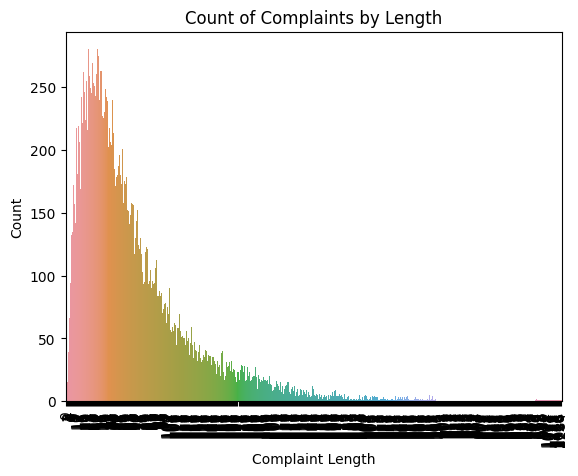

In [19]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint_len'] = df_clean['complaint_POS_removed'].apply(len)
sns.countplot(data=df_clean, x='complaint_len')

# Set labels and title
plt.xlabel('Complaint Length')
plt.ylabel('Count')
plt.title('Count of Complaints by Length')

# Rotate x-axis labels if needed
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [20]:
df_clean['complaint_len'].sort_values(ascending=False)

48112    2284
31952    2046
6262     1720
1096     1618
3612     1488
         ... 
4721        0
8588        0
7677        0
142         0
15185       0
Name: complaint_len, Length: 21072, dtype: int64

#### Find the top 40 words by frequency among all the articles after processing the text.

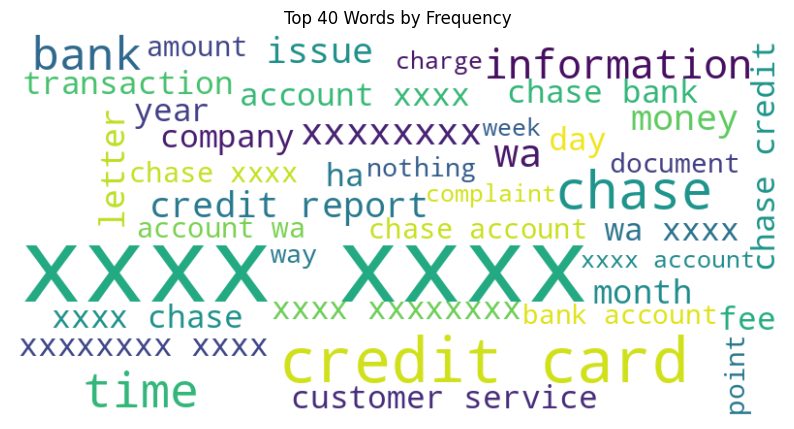

In [21]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud

# Combine all strings into a single text
all_text = ' '.join([text for sublist in df_clean['complaint_POS_removed'] for text in sublist])
# all_text

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, max_words=40, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 40 Words by Frequency')
plt.show()

In [22]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [ ]:

# Create a CountVectorizer instance to count the unigram frequencies
vectorizer = CountVectorizer(ngram_range=(1, 1))

# Fit the vectorizer on the cleaned complaints column
vectorizer.fit(df_clean['complaint_what_happened'])

# Get the unigram vocabulary and corresponding frequencies
dtm = vectorizer.transform(df_clean['complaint_what_happened'])

# Get the unigram vocabulary from the vectorizer
unigram_vocab = vectorizer.get_feature_names()

# Calculate the unigram frequencies
unigram_freq = dtm.sum(axis=0).tolist()[0]

# Create a dataframe to store the unigram frequencies
df_unigram_freq = pd.DataFrame({'Unigram': unigram_vocab, 'Frequency': unigram_freq})

# Sort the dataframe by frequency in descending order
df_unigram_freq = df_unigram_freq.sort_values(by='Frequency', ascending=False)

# Select the top 30 unigrams
top_30_unigrams = df_unigram_freq.head(30)

# Print the top 30 unigrams with their frequencies
top_30_unigrams

In [38]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).

from gensim.models import Word2Vec

# Load the Word2Vec model
model = Word2Vec()

# Assuming 'df_clean' is a pandas DataFrame containing cleaned text data
sentences = df_clean['complaint_POS_removed']  # Split text into word tokens

# Flatten the list of word tokens
words = [word for sentence in sentences for word in sentence]

# Calculate unigram frequencies
unigram_freq = pd.Series(words).value_counts()

# Select the top 30 unigrams
top_30_unigrams = unigram_freq.head(30)

# Print the top 30 unigrams with their frequencies
top_30_unigrams


xxxx           153992
i              140107
chase           51161
account         47665
wa              33877
credit          33094
card            29598
bank            28233
xxxxxxxx        22792
payment         21167
time            16038
day             12972
charge          12254
money           11961
loan            10982
check           10222
letter           9669
information      9653
fee              8729
transaction      8650
number           8605
month            8463
amount           8365
year             8292
ha               8258
mortgage         8179
customer         8163
balance          7754
company          7630
service          7595
dtype: int64

In [40]:
#Print the top 10 words in the unigram frequency
top_10_unigrams = unigram_freq.head(10)
top_10_unigrams

the      239148
i        193732
xxxx     192541
to       182013
and      145527
my       106625
a        106417
that      86291
chase     79844
was       79806
dtype: int64

In [25]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).

# Assuming 'df_clean' is a pandas DataFrame containing cleaned text data
complaints = df_clean['complaints']

# Create a CountVectorizer instance to count the bigram frequencies
vectorizer = CountVectorizer(ngram_range=(2, 2))

# Fit the vectorizer on the complaints column
vectorizer.fit(complaints)

# Transform the complaints column into a document-term matrix
dtm = vectorizer.transform(complaints)

# Get the bigram vocabulary from the vectorizer
bigram_vocab = vectorizer.get_feature_names()

# Calculate the bigram frequencies
bigram_freq = dtm.sum(axis=0).tolist()[0]

# Create a dataframe to store the bigram frequencies
df_bigram_freq = pd.DataFrame({'Bigram': bigram_vocab, 'Frequency': bigram_freq})

# Sort the dataframe by frequency in descending order
df_bigram_freq = df_bigram_freq.sort_values(by='Frequency', ascending=False)

# Select the top 30 bigrams
top_30_bigrams = df_bigram_freq.head(30)

# Print the top 30 bigrams with their frequencies
print(top_30_bigrams)


In [26]:
#Print the top 10 words in the bigram frequency

In [27]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).


In [28]:
#Print the top 10 words in the trigram frequency

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [29]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

AttributeError: ignored

In [ ]:
#All masked texts has been removed
df_clean

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
#Write your code here to initialise the TfidfVectorizer



#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [ ]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = #write the value you want to test out

#keep the random_state =40
nmf_model = #write your code here

In [ ]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

In [ ]:
#Print the Top15 words for each of the topics


In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4



In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = #write your code to assign topics to each rows.

In [ ]:
df_clean.head()

In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=

In [ ]:
training_data

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics



